<a href="https://colab.research.google.com/github/francescobellina/Repo_laboratorio_BiophotonicsI/blob/main/Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PATRICLE TRACKING AND DIFFUSION

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("ciao")

ciao


x_trajs shape: (9, 863), y_trajs shape: (9, 863)


/tmp/ipython-input-3875539057.py:33: RuntimeWarning: Mean of empty slice
  return np.nanmean((x_trajs[:, n] - x_trajs[:, 0])**2 + (y_trajs[:, n] - y_trajs[:, 0])**2)


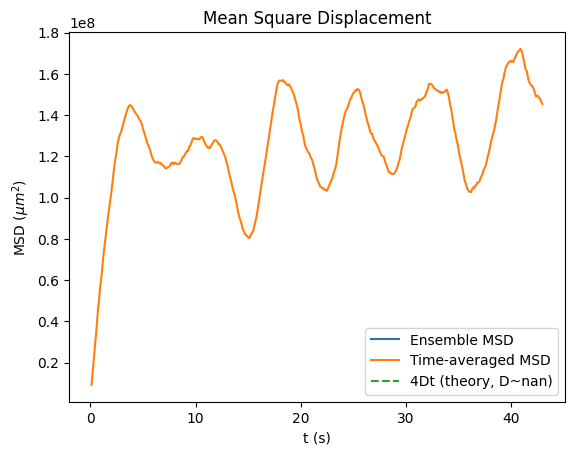

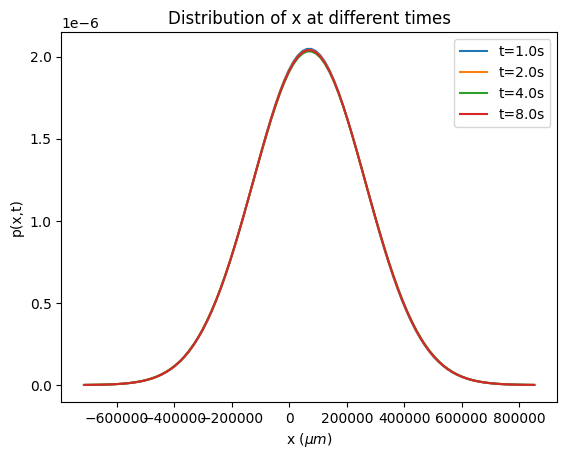

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

file_path = '/content/drive/MyDrive/Experiment_spots_002.csv'

# Legge il CSV ignorando eventuali intestazioni
df = pd.read_csv(file_path, header=None)

# Converte tutto in numerico (non numerici diventano NaN)
df = df.apply(pd.to_numeric, errors='coerce')

# Rimuove eventuali colonne completamente vuote
df = df.dropna(axis=1, how='all')

data = df.values

# Controlla numero di colonne
num_cols = data.shape[1]
if num_cols % 2 != 0:
    raise ValueError("Il file CSV deve avere un numero pari di colonne per dividere x e y.")

# Divide tra x e y
M = num_cols // 2
x_trajs = data[:, :M].astype(float).T
y_trajs = data[:, M:].astype(float).T

print(f'x_trajs shape: {x_trajs.shape}, y_trajs shape: {y_trajs.shape}')

# --- Funzioni MSD ---
def eaMSD(x_trajs, y_trajs, n):
    return np.nanmean((x_trajs[:, n] - x_trajs[:, 0])**2 + (y_trajs[:, n] - y_trajs[:, 0])**2)

def taMSD(x, y, n):
    disp = (x[n:] - x[:-n])**2 + (y[n:] - y[:-n])**2
    return np.nanmean(disp)

def msd_vs_time(x_trajs, y_trajs, max_lag):
    ea = [eaMSD(x_trajs, y_trajs, n) for n in range(1, max_lag)]
    ta = np.mean([[taMSD(x, y, n) for n in range(1, max_lag)] for x, y in zip(x_trajs, y_trajs)], axis=0)
    return ea, ta

# --- Parametri ---
M, N = x_trajs.shape
max_lag = N // 2
dt = 0.1
time = np.arange(N) * dt

# --- Calcolo MSD ---
ea, ta = msd_vs_time(x_trajs, y_trajs, max_lag)
lags = np.arange(1, max_lag) * dt

# --- Plot MSD ---
plt.figure()
plt.plot(lags, ea, label='Ensemble MSD')
plt.plot(lags, ta, label='Time-averaged MSD')

if len(ea) > 1:
    D_estimate = ea[1] / (4 * dt)
    plt.plot(lags, 4 * D_estimate * lags, '--', label=f'4Dt (theory, D~{D_estimate:.2f})')

plt.xlabel(r't (s)')
plt.ylabel(r'MSD ($\mu m^2$)')
plt.legend()
plt.title('Mean Square Displacement')
plt.show()

# --- Distribuzione di x ---
plt.figure()
for t_idx, t_col in zip([10, 20, 40, 80], ['b', 'r', 'g', 'c']):
    if t_idx < N:
        x_now = x_trajs[:, t_idx]
        mu, std = np.nanmean(x_now), np.nanstd(x_now)
        x_vals = np.linspace(mu - 4*std, mu + 4*std, 100)
        plt.plot(x_vals, norm.pdf(x_vals, mu, std), label=f't={time[t_idx]:.1f}s')

plt.xlabel(r'x ($\mu m$)')
plt.ylabel('p(x,t)')
plt.title('Distribution of x at different times')
plt.legend()
plt.show()